In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os



In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [ ]:
#This code can be used to extract pretrained CNN (ResNet) Features.
#It takes Image Path and returns 2048-dimensional feature.
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


In [ ]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                cnn_feature = cnn_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(cnn_feature)
                y.append(folder_name)

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
X

array([[0.27361682, 1.7197691 , 1.6426169 , ..., 0.07017896, 0.1112617 ,
        0.19807388],
       [0.3343964 , 1.0314474 , 0.7514031 , ..., 0.14761981, 0.13214383,
        0.0612594 ],
       [0.2807731 , 1.2727215 , 1.2301035 , ..., 0.20754363, 0.07287768,
        0.10784067],
       ...,
       [0.04832809, 1.4723983 , 0.03837677, ..., 0.10055459, 0.09310232,
        0.0533254 ],
       [0.26554283, 1.0144181 , 0.97670966, ..., 0.04118681, 0.0501596 ,
        0.16686897],
       [0.30453324, 0.9938912 , 1.1011769 , ..., 0.04553375, 0.03186749,
        0.24482122]], dtype=float32)

In [ ]:
y.shape

(1288,)

In [ ]:
X.shape

(1288, 2048)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [ ]:
print(lda.coef_.shape)

(7, 2048)


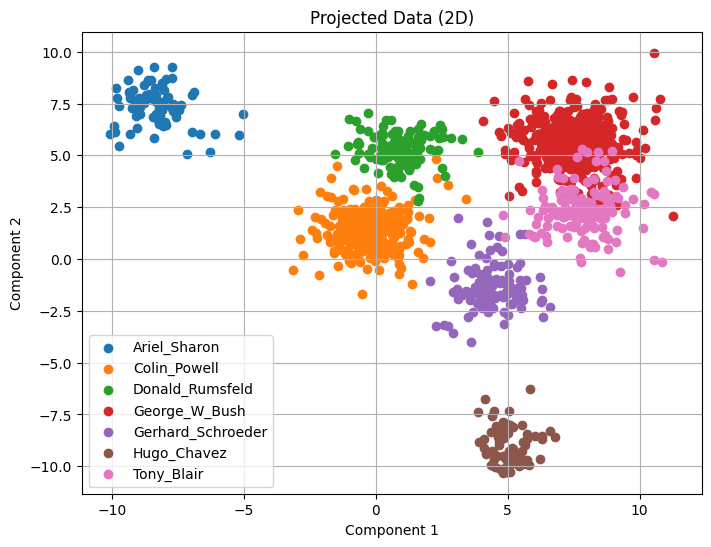

In [ ]:
# Get the sorted eigenvalues and eigenvectors
eigenvalues = lda.explained_variance_ratio_
eigenvectors = lda.scalings_

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 7 components
top_components = sorted_eigenvectors

# Project the data onto the top 7 components
X_projected = np.dot(X, top_components)

# Plot the projected data
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_projected[y == label, 0], X_projected[y == label, 1], label=label)
plt.title('Projected Data (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X_projected.shape  #so here the dimensionality reduced to 6 (n_classes-1, and in our data the number of classes are 7)

(1288, 6)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()


In [ ]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range ,)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [ ]:
y_pred=grid.predict(X_test)

In [ ]:
nn=grid.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors=3(best case) is: 0.9974160206718347


1.0